Dnes se podíváme na dva rojové algoritmy - ant colony optimization a particle swarm optimization.

Naimplementujeme je od základu (PSO jako úkol)

## Ant Colony Optimization

Algoritmus ACO se obzvlášť hodí pro kombinatorickou optimalizaci, konkrétně pro problémy, které se dají převést na hledání cest v grafu. Jako příklad si vezmeme TSPčko a použíjeme ACO pro jeho vyřešení -- tj. nalezení nejkratší Hamiltonské kružnice v úplném grafu.

In [11]:
from collections import namedtuple
import math
import functools

import numpy as np

Vertex = namedtuple('Vertex', ['name', 'x', 'y'])

# main ACO function
def ant_solver(vertices, distance, ants=10, max_iter=3000, alpha=1, beta=3, Q=100, rho=0.8):
    P = initialize_pheromone(len(vertices))
    best_sol = None
    best_fit = float('inf')
    for it in range(max_iter):
        sols = list(generate_solutions(vertices, P, distance, ants, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x), sols))
        P = update_pheromone(P, sols, fits, Q=Q, rho=rho)
        
        for s, f in zip(sols, fits):
            if f < best_fit:
                best_fit = f
                best_sol = s
        
        print(f'{it:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return best_sol, P

# compute distance
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

# compute fitness
def fitness(vertices, dist, sol):
    sd = 0
    for x, y in zip(sol, sol[1:]):
        sd += dist(vertices[x], vertices[y])
    sd += dist(vertices[sol[-1]], vertices[sol[0]])
    return sd

# pheromone initizalization
def initialize_pheromone(N):
    return 0.01 * np.ones(shape=(N,N))

# generate solution
def generate_solutions(vertices, P, dist, N, alpha=1, beta=3):
    
    # probability of selecting an edge (without scaling)
    def compute_prob(v1, v2):
        nu = 1 / dist(vertices[v1], vertices[v2])
        tau = P[v1, v2]
        ret = pow(tau, alpha) * pow(nu,beta)
        return ret if ret > 0.000001 else 0.000001

    V = P.shape[0]
    for i in range(N):
        available = list(range(V))
        sol = [np.random.randint(0, V)]
        available.remove(sol[0])
        while available:
            probs = np.array(list(map(lambda x: compute_prob(sol[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs)) # edge selection
            sol.append(selected)
            available.remove(selected)
        yield sol

def update_pheromone(P, sols, fits, Q=100, rho=0.6):
    ph_update = np.zeros(shape=P.shape)
    for s, f in zip(sols, fits):
        for x, y in zip(s, s[1:]):
            ph_update[x][y] += Q/f
        ph_update[s[-1]][s[0]] += Q/f
    
    return (1-rho)*P + ph_update        

In [4]:
import csv

# we will test the algorithm on european capitals
vertices = []
with open('cities.csv') as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

import pprint
        
pprint.pprint(vertices)

s, P = ant_solver(vertices, distance)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Rome', x

Vyplotíme si řešení a množství feromonů na každé hraně. Můžeme se také podívat (odkomentování zakomentované části "sol = ..."), jaký vliv mají alpha a beta na nalezená řešení.

Fitness:  227.96615074046937
[Vertex(name='Skopje', x=21.46666667, y=42.0),
 Vertex(name='Pristina', x=21.16666667, y=42.65),
 Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Podgorica', x=19.26666667, y=42.46666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Belgrade', x=20.5, y=44.81666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Bratislava', x=17.11666667, y=48.15),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Ljubljana', x=14.5, y=46.05),
 Vertex(name='San Marino', x=12.41666667, y=43.93333333),
 Vertex(name='Vatican City', x=12.45, y=41.9),
 Vertex(name='Rome', x=12.5, y=41.88333333),
 Vertex(name='Monaco', x=7.416666667, y=43.73333333),
 Vertex(name='Bern', x=7.433333333, y=46.95),
 Vertex(name='Vaduz', x=9.516666667, y=47.13333333),
 Vertex(name='Luxemburg', x=6.116666667, y=49.61666667),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 V

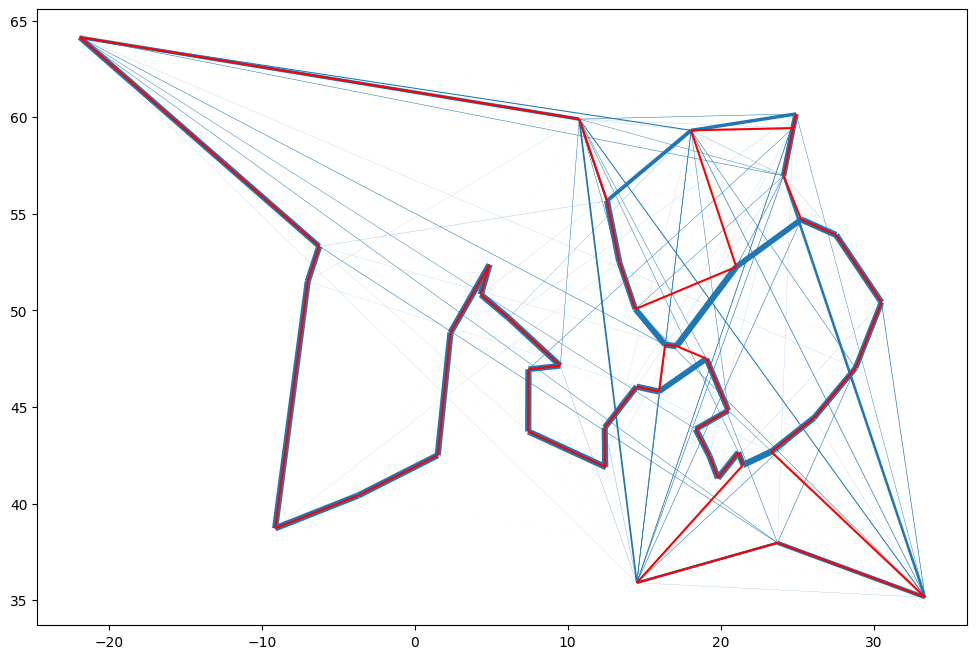

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

# plot the pheromone in blue, line width expresses the amount of pheromone on each edge
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(P[i][j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

best_sol = s # save the best solution (for the experiments below)

sol = best_sol

# we can test the effect of the parameters on the solution here
#sol = list(generate_solutions(vertices, P, distance, N=1, alpha=3, beta=1))[0]

# print the fitness of the solution
print('Fitness: ', fitness(vertices, distance, sol))

# print the order of the cities
sol_verts = [vertices[i] for i in sol]
pprint.pprint(sol_verts)

# plot the solution in red
sol_lines = []
for i, j in zip(sol, sol[1:]):
    sol_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])

sol_lines.append([(vertices[sol[-1]].x, vertices[sol[-1]].y), (vertices[sol[0]].x, vertices[sol[0]].y)])

sols_lc = mc.LineCollection(sol_lines, colors='red')
ax.add_collection(sols_lc)

## Particle Swarm Optimization

Nyní si zkuste naimplementovat PSO. Když budete hotovi, zkuste napsat nějaké hezké plotění swarmu během optimalizace (např. pomocí matplotlib. anymation a scatter)

In [7]:
class Particle:
    def __init__(self, x, v):
        self.x = x
        self.v = v
        self.p_best = x
            
    def __repr__(self):
        return str(self.x) + ', ' + str(self.v) + ', ' + str(self.p_best)

# simple fitness for testing
def fitness(x):
    return np.linalg.norm(x)

# main PSO implementation
def pso(fitness, swarm_size, problem_dim, max_iters, plot_speed=10):
    # TODO do birbs (algorithm body)
    pass

# random swarm initialization - locations and velocities
def init_swarm(N, D):
    # TODO init birbs
    pass

# global best update
def compute_gbest(swarm, fit):
    # TODO best birb
    pass

# swarm update - the main part of the algorithm
def update_swarm(swarm, fit, g_best, phi_p=1, phi_b=0.5, omega=0.95):
    # TODO update birbs (main algo step)
    pass

problem_dim = 5
pso(fitness, swarm_size=100, problem_dim=problem_dim, max_iters=120, plot_speed=10)